---
Author: Mustapha Bouhsen <br>
[LinkedIn](https://www.linkedin.com/in/mustapha-bouhsen/)<br>
[Git](https://github.com/mus514)<br>
Date: February 14, 2024<br>
---

In [0]:
%run Repos/bouhsen.m@gmail.com/ML_Pipeline_Hub/library/garch_model

In [0]:
%run Repos/bouhsen.m@gmail.com/ML_Pipeline_Hub/library/daily_utilities

## Simulation of the stock prince for the X next days using Monte-Carlo

In [0]:
#-----------------------------------------
# Set the prod folder path
#-----------------------------------------
raw_folder_path = "/mnt/raw/"
prod_folder_path = "/mnt/prod/"

stocks = ["aapl", "amzn", "googl", "msft"]

In [0]:
#-----------------------------------------
# Load the data
#-----------------------------------------
returns = spark.sql("SELECT * FROM stocks_returns").toPandas()
prices = spark.sql("SELECT * FROM stocks_prices").toPandas()

In [0]:
from datetime import timedelta
last_date = prices["date"].values[-1]

In [0]:
#--------------------------------------------------------
# Simultation of the prices for the 10 next days
#--------------------------------------------------------

# Set the number of days for the Monte Carlo simulation and the number of simulations
days = 250
n_sim = 1000

col_name = [f"{last_date + timedelta(days=i)}" for i in range(0, days+2)]
# Iterate through each stock
for stock in stocks:
    # Extract historical returns for the current stock
    r = returns[stock]

    # Generate Monte Carlo simulations of future returns for the specified number of days and simulations
    simret = forecast_return(r, days, n_sim)

    # Get the last price of the stock
    last_price = list(prices[stock])[-1]

    # Calculate simulated prices using the cumulative sum of simulated returns
    price = last_price * np.exp(np.cumsum(simret, axis=1))
    
    # build the data frame
    df_temp = pd.DataFrame(price.T)
    df_temp["date"] = col_name
    
    # Convert simulated prices to a Spark DataFrame with the specified schema
    df = spark.createDataFrame(df_temp)

    # Define the table name for the Monte Carlo simulation results
    table_name = f'{stock}_simulation'

    # Check if the table already exists in the Spark catalog
    if spark.catalog.tableExists(f"{table_name}"):
        # If the table exists, drop it
        spark.sql(f"DROP TABLE {table_name}")
        print(f'Dropped table: {table_name}')

    # Create a new table with the simulated prices
    df.write.format("parquet").saveAsTable(table_name) 

    # Write the returns in the prod
    # Temp folder to save temp parquet files
    temp_folder = prod_folder_path + 'temp/'

    # Write files in folders 
    df.coalesce(1).write.mode("overwrite").option("header", "True").csv(temp_folder)

    # get all files path ending with .parquet
    files_paths = get_files_paths_from_folders(temp_folder, ".csv")

    # Copy parquet files to final destination
    ingest_and_transform_to_parquet(files_paths, prod_folder_path, f"{stock}_simulation")

    # delete the temp folder
    delete_contents_recursively(temp_folder)

Dropped table: aapl_simulation
Dropped table: amzn_simulation
Dropped table: googl_simulation
Dropped table: msft_simulation


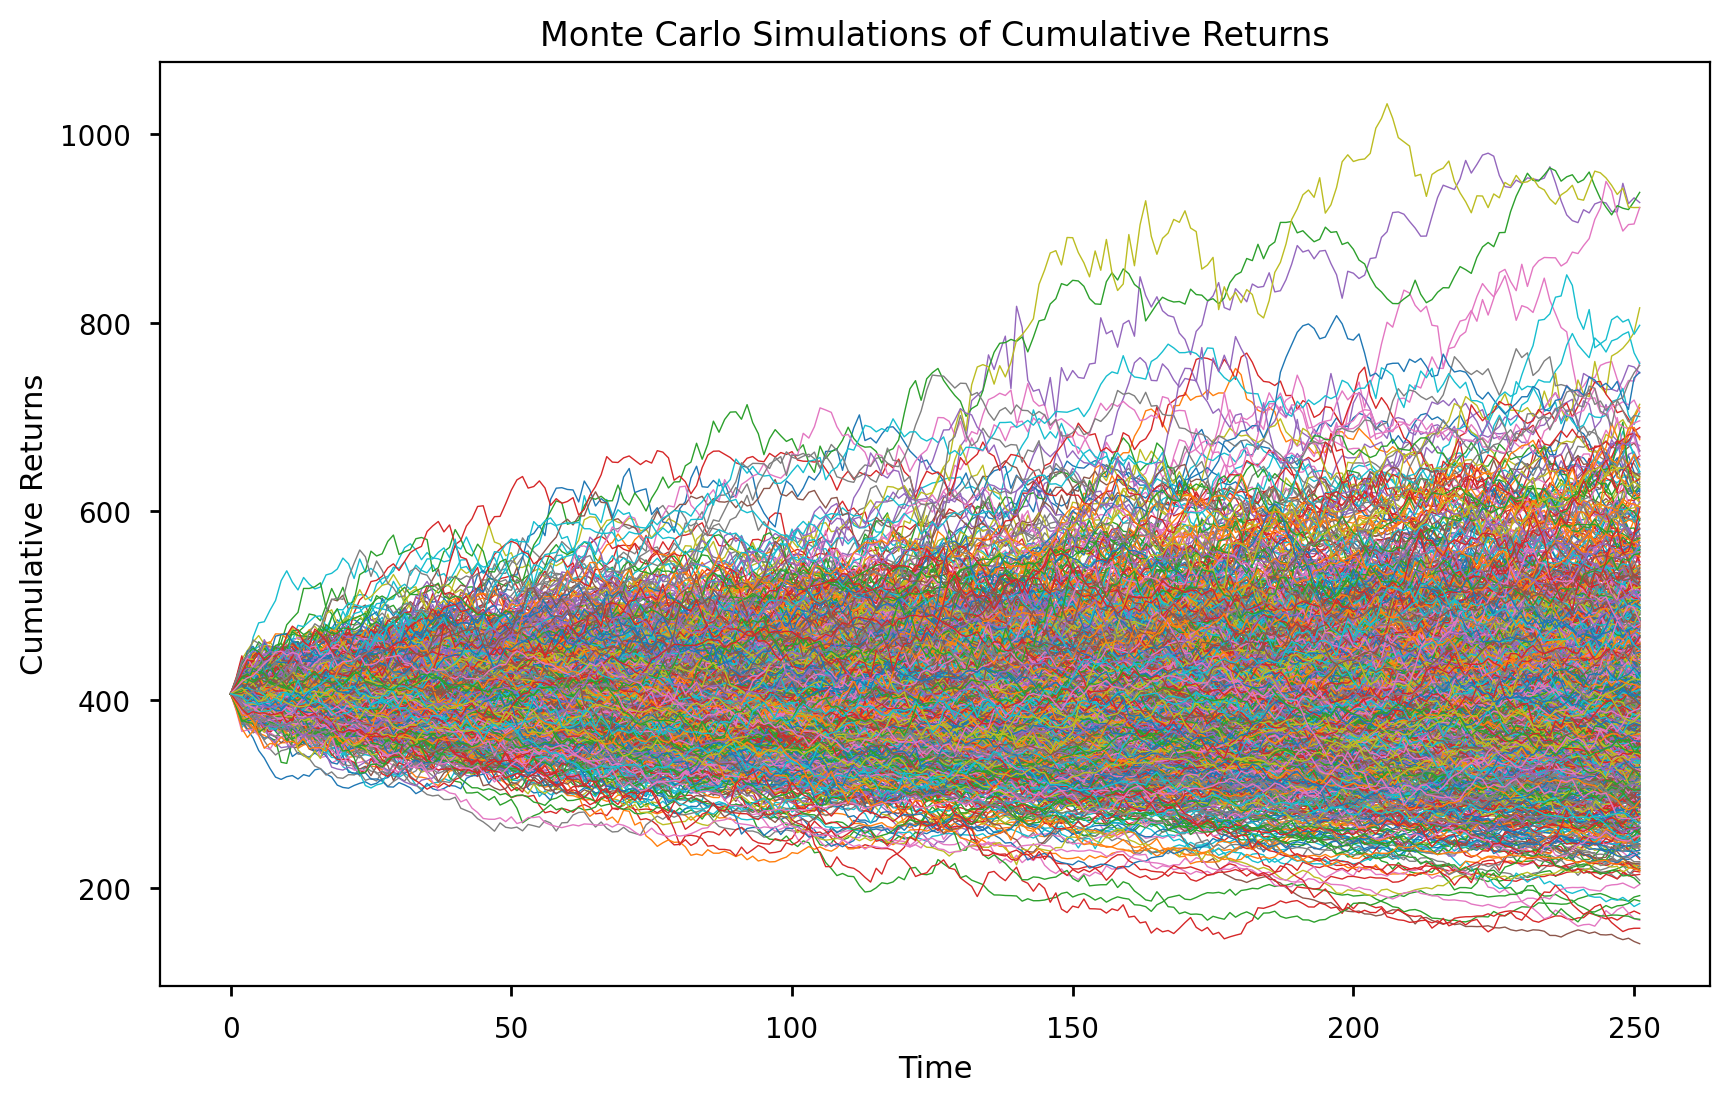

In [0]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(price.T, linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Monte Carlo Simulations of Cumulative Returns')
plt.show()